### This notebook checks all the features one by one, filling in null values and ordalizing ordinal features. The export of this notebook will be used in all the machine learning models.

In [1]:
import numpy as np # had to downgrade NumPy to resolve compatiblity issue
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
housing.shape

(2580, 81)

In [3]:
housing.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 1 to 763
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2580 non-null   int64  
 1   GrLivArea      2580 non-null   int64  
 2   SalePrice      2580 non-null   int64  
 3   MSSubClass     2580 non-null   int64  
 4   MSZoning       2580 non-null   object 
 5   LotFrontage    2118 non-null   float64
 6   LotArea        2580 non-null   int64  
 7   Street         2580 non-null   object 
 8   Alley          168 non-null    object 
 9   LotShape       2580 non-null   object 
 10  LandContour    2580 non-null   object 
 11  Utilities      2580 non-null   object 
 12  LotConfig      2580 non-null   object 
 13  LandSlope      2580 non-null   object 
 14  Neighborhood   2580 non-null   object 
 15  Condition1     2580 non-null   object 
 16  Condition2     2580 non-null   object 
 17  BldgType       2580 non-null   object 
 18  HouseStyle    

In [4]:
# RE_data = pd.read_csv('Ames_Real_Estate_Data.csv', index_col=0)
# RE_data.shape

In [5]:
#RE_data.info(verbose = True)

### Handling duplicates

In [6]:
# check dulicated rows
housing.groupby('PID').filter(lambda x: len(x) > 1)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
817,909276070,1717,194000,50,RL,80.0,12400,Pave,NaN,Reg,...,113,0,NaN,NaN,NaN,0,2,2006,WD,Normal
1,909276070,1717,194000,50,RL,80.0,12400,Pave,NaN,Reg,...,113,0,NaN,NaN,NaN,0,2,2006,WD,Normal


In [7]:
# if a house had multiple transactions in the data frame, I elected to keep only the most recent sales data on any property
housing = housing.sort_values(by=['PID', 'YrSold','MoSold'], ascending=[True, False, False])
housing.drop_duplicates(subset='PID', keep='first', inplace=True)

In [8]:
# double check
housing.groupby('PID').filter(lambda x: len(x) > 1)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


### Taking out non-residential zoning transactions and abnormal / family transactions

In [9]:
# Only keeps MSZoning = RH, RL or RM which represents Residential zoning
# Only keeps SaleCondition, meaning the Condition of sale is not Abnormal Sale -  trade, foreclosure, short sale or Sale between family members
housing = housing[
    (housing['MSZoning'].isin(['RL', 'RM', 'RH'])) &
    (~housing['SaleCondition'].isin(['Abnorml', 'Family']))
]
housing

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
224,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
323,526302030,1293,149900,20,RL,NaN,11027,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
898,526302040,1024,157500,20,RL,85.0,10533,Pave,NaN,IR1,...,280,0,NaN,NaN,NaN,0,8,2006,WD,Normal
423,526302110,882,124500,20,RL,74.0,13008,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
542,526302120,1797,169000,20,RL,NaN,11765,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,924100060,1632,173000,60,RL,70.0,10457,Pave,NaN,IR1,...,0,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal
768,924100070,1389,170000,20,RL,77.0,10010,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
477,924151040,1803,285000,20,RL,76.0,9892,Pave,NaN,Reg,...,0,0,NaN,GdWo,NaN,0,2,2010,WD,Normal
281,924151050,2000,188000,60,RL,74.0,9627,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


### Train/Test Split Decision

* In a real-world scenario, we would train our model using housing transactions from **2006–2009** and then generate predictions for **2010**.
* To better reflect this setup, I chose **not** to follow the conventional 70%/30% random train/test split.
* Instead, I used houses sold between **2006–2009** as the **training data** and reserved houses sold in **2010** as the **test set**. Under this setup, the train/test split ended up being close to 88%/12%.
* **Rationale:** Using chronological splits simulates how the model would perform on *future, unseen* data, which mirrors a true forecasting task. This approach also helps prevent **data leakage**—avoiding situations where information from the future (2010 sales) could inadvertently influence model training.

In [10]:
housing.YrSold.value_counts(normalize=True)

YrSold
2007    0.235046
2009    0.229149
2008    0.215249
2006    0.199242
2010    0.121314
Name: proportion, dtype: float64

## Treatment of Features:
- All null values in all features need to be checked and filled with values
- Nominal Variables (Categorical, No Order) need to be dummified 
- Ordinal Variables (Categorical, With Order) need to be ordinalized
- Discrete Variables (Quantitative, Countable)
- Continuous Variables (Quantitative, Measurable)

### High level overview of missingness in columns

PoolQC          99.620893
MiscFeature     95.956192
Alley           95.029486
Fence           78.896377
MasVnrType      60.657119
FireplaceQu     47.262005
LotFrontage     18.155013
GarageYrBlt      4.928391
GarageFinish     4.928391
GarageQual       4.928391
GarageCond       4.928391
GarageType       4.844145
BsmtExposure     2.864364
BsmtFinType2     2.822241
BsmtFinType1     2.780118
BsmtCond         2.780118
BsmtQual         2.780118
MasVnrArea       0.421230
Electrical       0.042123
BsmtFullBath     0.042123
GarageCars       0.042123
GarageArea       0.042123
BsmtHalfBath     0.042123
dtype: float64


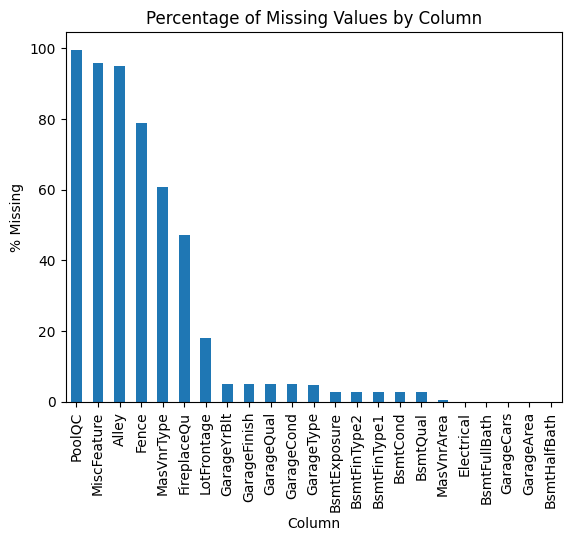

In [11]:
# Calculate % missing
missing_percent = housing.isna().mean() * 100

# Filter only columns with missing values
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)


print(missing_percent)

missing_percent.sort_values(ascending=False).plot.bar()
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% Missing')
plt.xlabel('Column')
plt.show()

### Data distribution of each feature

array([[<Axes: title={'center': 'PID'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>],
       [<Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>],
       [<Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>],
       [<Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}

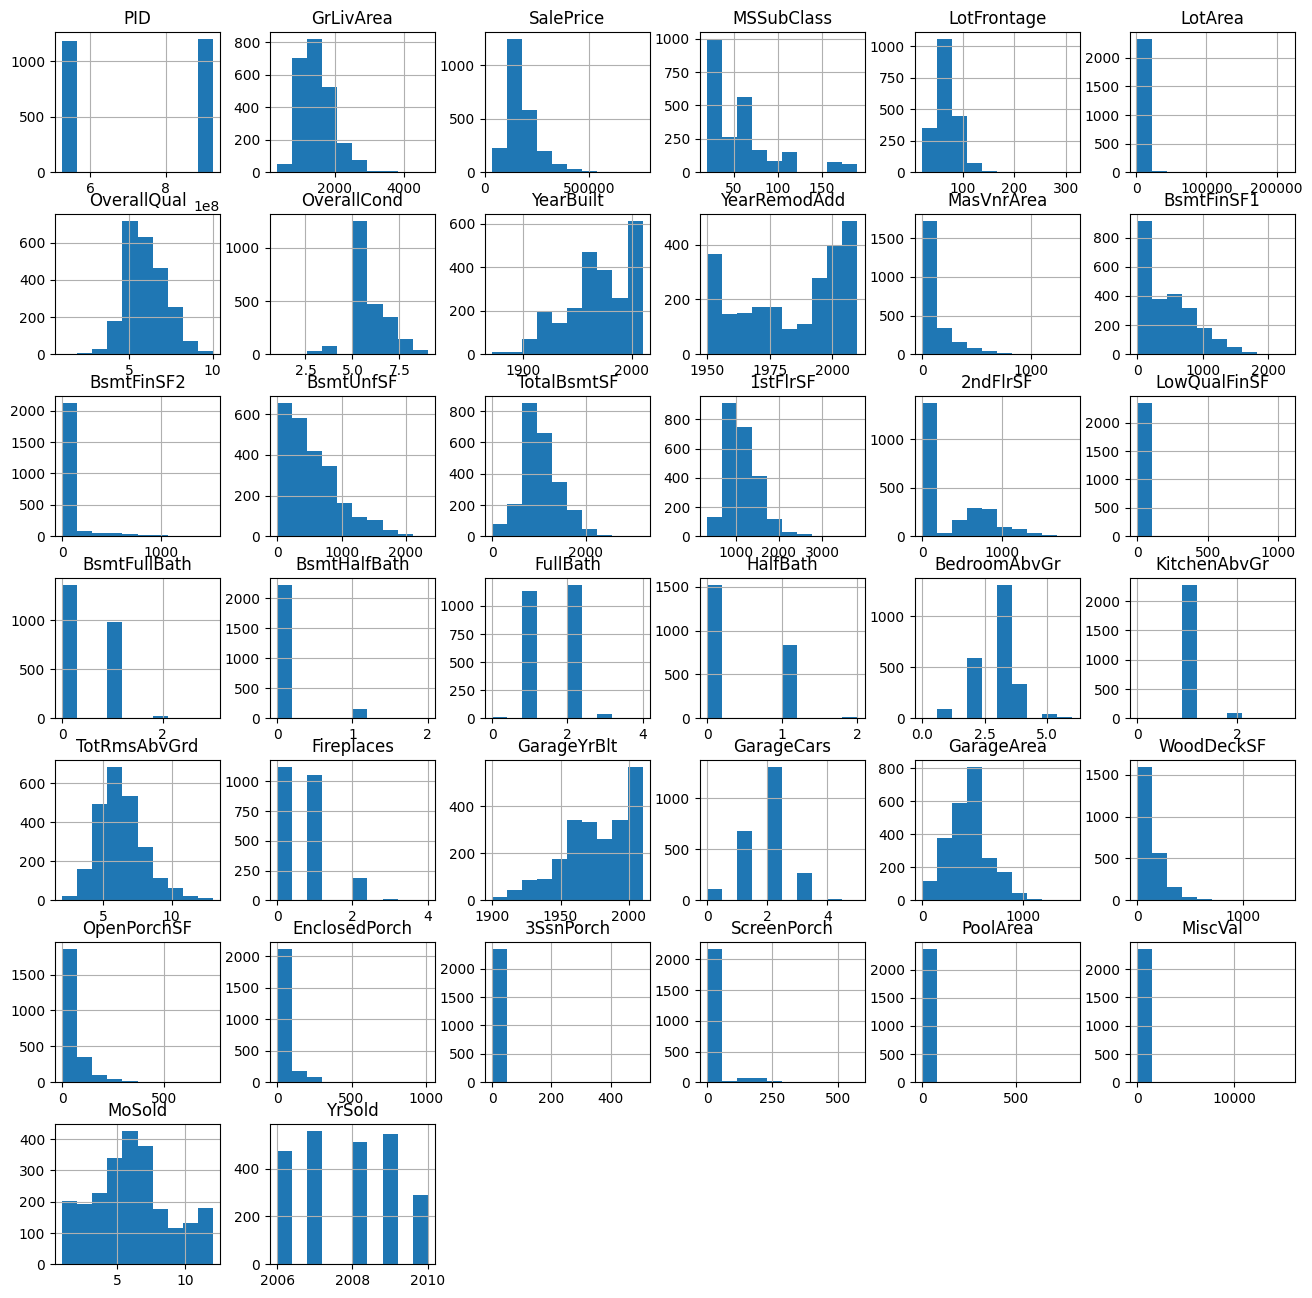

In [12]:
housing.hist(figsize=(16, 16))

### Create mapping used by many ordinal variables

In [13]:
# Instead of ordinalizing "NA" to 0, assign it to a distinct value outside the ordered range, like -1
# This makes it clearer in the feature space that "NA" is not part of the ordered scale.
# Linear models and trees will treat -1 as a separate signal.
qual_cond_map = {
    'Ex': 5,   # Excellent
    'Gd': 4,   # Good
    'TA': 3,   # Typical/Average
    'Fa': 2,   # Fair
    'Po': 1,    # Poor
    'NA': -1    # Not Applicable
}

### We will categorize all the features into below sections and start checking it one by one

### Lot Information

In [14]:
housing.loc[ :,['MSZoning','LotFrontage','LotArea','Street',
                'Alley','LotShape','LandContour','LotConfig',
                'LandSlope','Neighborhood','Condition1','Condition2']].isnull().sum()

MSZoning           0
LotFrontage      431
LotArea            0
Street             0
Alley           2256
LotShape           0
LandContour        0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
dtype: int64

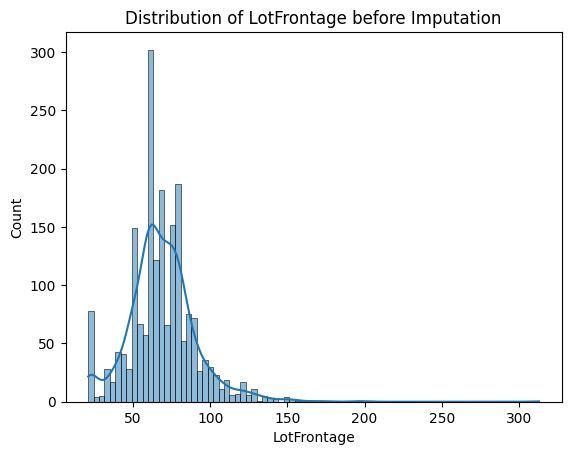

In [15]:
# Visualize LotFrontage Distribution Before
sns.histplot(housing['LotFrontage'], kde=True)
plt.title('Distribution of LotFrontage before Imputation')
plt.show()

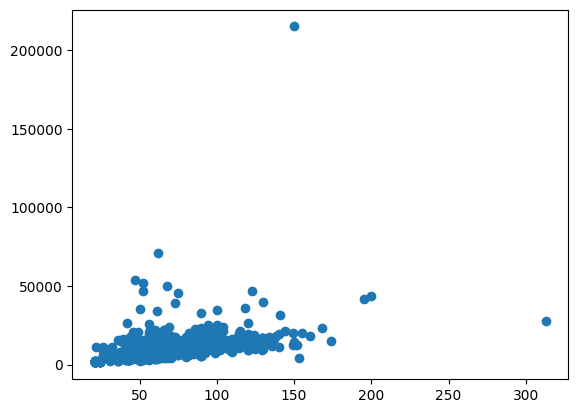

In [16]:
# check if there is a linear relationship between LotFrontage and LotArea
plt.scatter(housing.LotFrontage, housing.LotArea)
#sns.scatterplot(data=housing, x='LotFrontage', y='LotArea', hue='LotShape')

### To avoid data leakage, I filled missing values in LotFrontage using imputation values derived exclusively from the training dataset.

In [17]:
# Median LotFrontage per Neighborhood, MSZoning and LotShape from houses sold between year 2006 - 2009
lotfrontage_by_group = (
    housing.loc[housing['YrSold'].between(2006, 2009)]
    .groupby(['Neighborhood', 'MSZoning', 'LotShape'])['LotFrontage']
    .median()
)

# Define a function to apply the imputation
def impute_lotfrontage(row):
    if pd.isnull(row['LotFrontage']):
        return lotfrontage_by_group.loc[(row['Neighborhood'], row['MSZoning'], row['LotShape'])]
    else:
        return row['LotFrontage']

housing['LotFrontage'] = housing.apply(impute_lotfrontage, axis=1)

In [18]:
# check if still any nulls
housing[(housing['LotFrontage'].isnull())]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
699,527452060,958,143750,120,RL,NaN,4928,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
214,527452100,958,128000,120,RL,NaN,4928,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,2,2007,WD,Normal
252,528228405,1576,219990,120,RM,NaN,3940,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
930,528228415,1414,178740,120,RM,NaN,3072,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal
487,528228430,1548,225000,120,RM,NaN,3072,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Normal
497,531385130,1494,215000,20,RL,NaN,16196,Pave,NaN,IR3,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
541,532353050,912,144000,20,RL,NaN,12968,Pave,NaN,IR2,...,176,0,NaN,NaN,NaN,0,9,2008,WD,Normal
490,534127190,2156,262500,20,RL,NaN,20781,Pave,NaN,IR2,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
710,535181030,1657,163500,20,RL,NaN,12155,Pave,NaN,IR3,...,147,0,NaN,NaN,NaN,0,3,2007,WD,Normal
939,903452025,768,93850,30,RM,NaN,6291,Grvl,NaN,IR1,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [19]:
# Median LotFrontage per MSZoning and LotShape to address nulls from above logic
lotfrontage_by_group = (
    housing.loc[housing['YrSold'].between(2006, 2009)]
    .groupby(['MSZoning', 'LotShape'])['LotFrontage']
    .median()
)
    
# Define a function to apply the imputation
def impute_lotfrontage(row):
    if pd.isnull(row['LotFrontage']):
        return lotfrontage_by_group.loc[(row['MSZoning'], row['LotShape'])]
    else:
        return row['LotFrontage']

housing['LotFrontage'] = housing.apply(impute_lotfrontage, axis=1)

In [20]:
# check if still any nulls
housing[(housing['LotFrontage'].isnull())]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


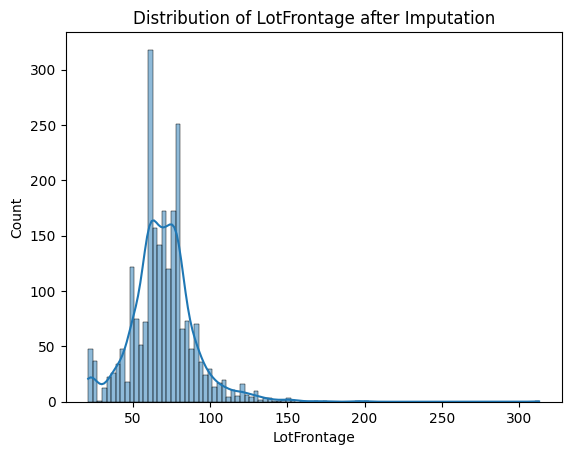

In [21]:
# Visualize LotFrontage Distribution After
sns.histplot(housing['LotFrontage'], kde=True)
plt.title('Distribution of LotFrontage after Imputation')
plt.show()

In [22]:
# fill in nulls for Alley
# given that more than 90% of the feature Alley has null value, I will assign NA to these nulls
housing['Alley'] = housing['Alley'].fillna('NA')

In [23]:
# combine 'Condition1','Condition2'
housing['condition'] = np.where(
    housing['Condition1'] == housing['Condition2'],
    housing['Condition1'],
    housing['Condition1'] + '_' + housing['Condition2']
)

In [24]:
# double check before dropping the original columns
housing.loc[:, ['Condition1','Condition2','condition']]

,Condition1,Condition2,condition
224,Norm,Norm,Norm
323,Norm,Norm,Norm
898,Norm,Norm,Norm
423,Norm,Norm,Norm
542,Norm,Norm,Norm
...,...,...,...
439,Norm,Norm,Norm
768,Norm,Norm,Norm
477,Norm,Norm,Norm
281,Norm,Norm,Norm


In [25]:
housing.drop(columns=['Condition1','Condition2'], inplace=True)

### Garage

In [26]:
housing.loc[ :,['GarageType','GarageYrBlt','GarageFinish','GarageCars',
                'GarageArea','GarageQual','GarageCond','PavedDrive']].isnull().sum()

GarageType      115
GarageYrBlt     117
GarageFinish    117
GarageCars        1
GarageArea        1
GarageQual      117
GarageCond      117
PavedDrive        0
dtype: int64

In [27]:
housing.loc[ :,['GarageType','GarageYrBlt','GarageFinish','GarageCars',
                'GarageArea','GarageQual','GarageCond','PavedDrive']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive
224,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P
323,Attchd,1954.0,RFn,2.0,452.0,TA,TA,Y
898,Attchd,1956.0,Unf,1.0,313.0,TA,TA,Y
423,Attchd,1956.0,Unf,1.0,502.0,TA,TA,Y
542,Attchd,1957.0,Unf,3.0,963.0,TA,TA,Y
...,...,...,...,...,...,...,...,...
439,Attchd,1969.0,RFn,2.0,898.0,TA,TA,Y
768,Attchd,1975.0,RFn,2.0,418.0,TA,TA,Y
477,Attchd,1994.0,Unf,2.0,482.0,TA,TA,Y
281,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y


In [28]:
# check missingness for GarageType
# all houses missing GarageType have zero GarageCars / GarageArea
housing[housing['GarageType'].isnull()][['GarageArea']].value_counts()

GarageArea
0.0           115
Name: count, dtype: int64

In [29]:
housing[(housing['GarageYrBlt'].isnull()) & (housing['GarageType'] == 'Detchd')]['PID']

532    903426160
434    910201180
Name: PID, dtype: int64

In [30]:
# fill values for GarageYrBlt
housing['GarageType'] = housing['GarageType'].fillna('NA')
#housing['GarageYrBlt'] = housing['GarageYrBlt'].fillna(-1) # use -1 to represent NA, this treatment is consistent throughout this notebook

# use YearBuilt as an estimate for 2 houses that do have garages but have null GarageYrBlt
housing['GarageYrBlt'] = np.where(
    housing['GarageYrBlt'].notnull(),
    housing['GarageYrBlt'],
    np.where(
        housing['GarageType'] == 'NA',
        -1,                              
        housing['YearBuilt']                              
    )
)

In [31]:
# to check if above formula works
housing[(housing['GarageType'].isnull()) & (housing['GarageType'] == 'Detchd')]
housing.GarageYrBlt.isnull().sum()

0

In [32]:
# when GarageFinish is null, 2 houses have Detchd garage and 127 houses have no garage
#housing[housing['GarageFinish'].isnull()][['GarageType']].value_counts()

# use OverallCond to see what is the most likely type of GarageFinish for GarageType == Detchd
# OverallCond = 6 and 8 for these 2 houses
housing[(housing['GarageFinish'].isnull()) & (housing['GarageType'] == 'Detchd')][['PID','OverallCond']]

# OverallCond bucket 6 and 8 with Garagetype Detchd. what type of GarageFinish would them have?
# most of the houses in the buckets above have Unf GarageFinish
# I decided to assign Unf to these 2 houses
housing[(housing['OverallCond'] == 6) & (housing['GarageType'] == 'Detchd')][['GarageFinish']].value_counts()
housing[(housing['OverallCond'] == 8) & (housing['GarageType'] == 'Detchd')][['GarageFinish']].value_counts()


# fill in nulls for GarageFinish
housing['GarageFinish'] = np.where(
    housing['GarageFinish'].notnull(),
    housing['GarageFinish'],
    np.where(
        housing['GarageType'] == 'NA',
        'NA',                              
        'Unf'                              
    )
)

In [33]:
# ordinalize GarageFinish column
garagefinish_map = {
        "Fin": 3, # Finished
        "RFn": 2, # Rough Finished
        "Unf": 1, # Unfinished
        "NA": -1, # No Garage
}

housing['GarageFinish_ordinal'] = housing['GarageFinish'].map(garagefinish_map)

In [34]:
# rename GarageFinish column
housing.rename(columns={'GarageFinish': 'GarageFinish_todrop'}, inplace=True)

In [35]:
# check missingness in GarageCars and GarageArea
# 1 house missing both fields
housing[(housing['GarageCars'].isnull()) | (housing['GarageArea'].isnull())][['PID','GarageType','GarageFinish_todrop']]

,PID,GarageType,GarageFinish_todrop
434,910201180,Detchd,Unf


In [36]:
# what is the relationship between GarageCars and GarageArea?
# two features are highly correlated
housing['GarageCars'].corr(housing['GarageArea'])

0.8908514912995118

In [37]:
# find out min GarageCars and GarageArea to this house that have null in GarageCars and GarageArea 
print(
    housing.loc[
    (housing['GarageCars'].notnull()) & 
    (housing['GarageType'] == 'Detchd'),
    'GarageCars'
].min()
)

print(
    housing.loc[
    (housing['GarageArea'].notnull()) & 
    (housing['GarageType'] == 'Detchd'),
    'GarageArea'
].min()
)

1.0
100.0


In [38]:
# fill in nulls in GarageCars and GarageArea
housing.loc[housing['PID'] == 910201180, 'GarageCars'] = 1
housing.loc[housing['PID'] == 910201180, 'GarageArea'] = 100

In [39]:
# check
housing.GarageCars.isnull().sum()
housing.GarageArea.isnull().sum()

0

In [40]:
# check missingness in 'GarageQual','GarageCond'
housing[housing['GarageQual'].isnull()][['GarageType']].value_counts()
housing[housing['GarageCond'].isnull()][['GarageType']].value_counts()

GarageType
NA            115
Detchd          2
Name: count, dtype: int64

In [41]:
# locate 2 houses with garages but have null in 'GarageQual','GarageCond'
housing[
    (housing['GarageQual'].isnull()) & (housing['GarageType'] == 'Detchd')][['PID','GarageType','GarageFinish_todrop']]

,PID,GarageType,GarageFinish_todrop
532,903426160,Detchd,Unf
434,910201180,Detchd,Unf


In [42]:
# for houses with Unf garagefinish and Detchd garagetype, TA is the most likely GarageQual and GarageCond
housing[
    (housing['GarageFinish_todrop'] == 'Unf') & 
    (housing['GarageType'] == 'Detchd') &
    (housing['GarageQual'].notnull())
][['GarageQual']].value_counts()

housing[
    (housing['GarageFinish_todrop'] == 'Unf') & 
    (housing['GarageType'] == 'Detchd') &
    (housing['GarageQual'].notnull())
][['GarageCond']].value_counts()

GarageCond
TA            537
Fa             55
Po              8
Gd              2
Ex              1
Name: count, dtype: int64

In [43]:
# fill in nulls for GarageFinish
housing['GarageQual'] = np.where(
    housing['GarageQual'].notnull(),
    housing['GarageQual'],
    np.where(
        housing['GarageType'] == 'NA',
        'NA',                              
        'TA'                              
    )
)


housing['GarageCond'] = np.where(
    housing['GarageCond'].notnull(),
    housing['GarageCond'],
    np.where(
        housing['GarageType'] == 'NA',
        'NA',                              
        'TA'                              
    )
)

In [44]:
# ordalize GarageQual & GarageCond
housing['GarageQual_ordinal'] = housing['GarageQual'].map(qual_cond_map)
housing['GarageCond_ordinal'] = housing['GarageCond'].map(qual_cond_map)

In [45]:
# rename GarageQual & GarageCond
housing.rename(columns={'GarageQual': 'GarageQual_todrop'}, inplace=True)
housing.rename(columns={'GarageCond': 'GarageCond_todrop'}, inplace=True)

In [46]:
# ordinalize PavedDrive column
paveddr_map = {
        "Y": 3, # Paved
        "P": 2, # Partial Pavement
        "N": 1, # Dirt/Gravel
}

housing['PavedDrive_ordinal'] = housing['PavedDrive'].map(paveddr_map)

In [47]:
# rename PavedDrive
housing.rename(columns={'PavedDrive': 'PavedDrive_todrop'}, inplace=True)

### Amenities

In [48]:
housing.loc[ :,['Fireplaces','FireplaceQu','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'PoolQC','Fence','MiscFeature','MiscVal']].isnull().sum()

Fireplaces          0
FireplaceQu      1122
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           2365
Fence            1873
MiscFeature      2278
MiscVal             0
dtype: int64

In [49]:
housing.loc[ :,['WoodDeckSF','OpenPorchSF',
                'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'PoolQC','Fence','MiscFeature','MiscVal']]

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal
224,210,62,0,0,0,0,NaN,NaN,NaN,0
323,280,0,0,0,0,0,NaN,NaN,NaN,0
898,0,0,0,0,280,0,NaN,NaN,NaN,0
423,0,0,0,0,0,0,NaN,NaN,NaN,0
542,0,0,0,0,0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
439,0,173,368,0,0,0,NaN,MnPrv,NaN,0
768,240,38,0,0,0,0,NaN,NaN,NaN,0
477,129,64,222,0,0,0,NaN,GdWo,NaN,0
281,190,48,0,0,0,0,NaN,NaN,NaN,0


In [50]:
# check missingness for FireplaceQu
# houses missing FireplaceQu is because they don't have fireplaces
housing[housing['FireplaceQu'].isnull()][['Fireplaces']].value_counts()

Fireplaces
0             1122
Name: count, dtype: int64

In [51]:
# fill values for nulls
housing['FireplaceQu'] = housing['FireplaceQu'].fillna('NA')

housing['PoolQC'] = housing['PoolQC'].fillna('NA')
housing['Fence'] = housing['Fence'].fillna('NA')
housing['MiscFeature'] = housing['MiscFeature'].fillna('NA')

In [52]:
# ordinalize FireplaceQu, PoolQC
housing['FireplaceQu_ordinal'] = housing['FireplaceQu'].map(qual_cond_map)
housing['PoolQC_ordinal'] = housing['PoolQC'].map(qual_cond_map)

In [53]:
# rename FireplaceQu, PoolQC column
housing.rename(columns={'FireplaceQu': 'FireplaceQu_todrop'}, inplace=True)
housing.rename(columns={'PoolQC': 'PoolQC_todrop'}, inplace=True) 

In [54]:
housing.PoolQC_todrop.value_counts()

PoolQC_todrop
NA    2365
TA       3
Fa       2
Ex       2
Gd       2
Name: count, dtype: int64

### Sale Information

In [55]:
housing.loc[ :,['SalePrice','MoSold','YrSold',
               'SaleType','SaleCondition']].isnull().sum()

SalePrice        0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
dtype: int64

In [56]:
housing.loc[ :,['SalePrice','MoSold','YrSold',
               'SaleType','SaleCondition']]

,SalePrice,MoSold,YrSold,SaleType,SaleCondition
224,215000,5,2010,WD,Normal
323,149900,5,2006,WD,Normal
898,157500,8,2006,WD,Normal
423,124500,10,2009,WD,Normal
542,169000,6,2006,WD,Normal
...,...,...,...,...,...
439,173000,4,2009,WD,Normal
768,170000,4,2006,WD,Normal
477,285000,2,2010,WD,Normal
281,188000,11,2006,WD,Normal


In [57]:
housing.SaleCondition.value_counts()

SaleCondition
Normal     2305
Partial      63
Alloca        4
AdjLand       2
Name: count, dtype: int64

### House General Information

In [58]:
housing.loc[ :,['PID','GrLivArea','1stFlrSF',
               '2ndFlrSF','LowQualFinSF','BedroomAbvGr','TotRmsAbvGrd',
               'Functional']].isnull().sum()

PID             0
GrLivArea       0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
BedroomAbvGr    0
TotRmsAbvGrd    0
Functional      0
dtype: int64

In [59]:
housing.loc[ :,['PID','GrLivArea','1stFlrSF',
               '2ndFlrSF','LowQualFinSF','BedroomAbvGr','TotRmsAbvGrd',
               'Functional']]

,PID,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF,BedroomAbvGr,TotRmsAbvGrd,Functional
224,526301100,1656,1656,0,0,3,7,Typ
323,526302030,1293,1293,0,0,2,5,Typ
898,526302040,1024,1024,0,0,2,5,Typ
423,526302110,882,882,0,0,2,5,Typ
542,526302120,1797,1797,0,0,3,7,Typ
...,...,...,...,...,...,...,...,...
439,924100060,1632,784,848,0,4,7,Typ
768,924100070,1389,1389,0,0,2,6,Typ
477,924151040,1803,1803,0,0,3,6,Typ
281,924151050,2000,996,1004,0,3,9,Typ


In [60]:
# ordinalize Functional column
functionality_map = {
        "Typ": 8, # Typical Functionality
        "Min1": 7, # Minor Deductions 1
        "Min2": 6, # Minor Deductions 2
        "Mod": 5, # Moderate Deductions
        "Maj1": 4, # Major Deductions 1
        "Maj2": 3, # Major Deductions 2
        "Sev": 2, # Severely Damaged
        "Sal": 1, # Salvage only
}

housing['Functional_ordinal'] = housing['Functional'].map(functionality_map)

In [61]:
# rename Functional column
housing.rename(columns={'Functional': 'Functional_todrop'}, inplace=True)

### GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF

In [62]:
# check multicollinearity among 1stFlrSF, 2ndFlrSF, LowQualFinSF and GrLivArea
# need to remove GrLivArea in regression models
check = np.isclose(
    housing['1stFlrSF'] + housing['2ndFlrSF'] + housing['LowQualFinSF'],
    housing['GrLivArea']
)
check.sum()

2374

In [63]:
housing.loc[ :,['MSSubClass','BldgType','HouseStyle','OverallQual',
                'OverallCond','YearBuilt','YearRemodAdd']].isnull().sum()

MSSubClass      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [64]:
housing.loc[ :,['MSSubClass','BldgType','HouseStyle','OverallQual',
                'OverallCond','YearBuilt','YearRemodAdd']]

,MSSubClass,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd
224,20,1Fam,1Story,6,5,1960,1960
323,20,1Fam,1Story,6,5,1954,1954
898,20,1Fam,1Story,6,6,1956,1956
423,20,1Fam,1Story,6,5,1956,1956
542,20,1Fam,1Story,5,5,1957,1957
...,...,...,...,...,...,...,...
439,60,1Fam,2Story,5,7,1969,1969
768,20,1Fam,1Story,5,5,1974,1975
477,20,1Fam,1Story,8,5,1994,1995
281,60,1Fam,2Story,7,5,1993,1994


In [65]:
# below columns are ordinal features already
print(housing['OverallQual'].dtype)
print(housing['OverallCond'].dtype)

int64
int64


In [66]:
print(housing['YearBuilt'].dtype)
print(housing['YearRemodAdd'].dtype)

int64
int64


### Kitchen

In [67]:
housing.loc[ :,['KitchenAbvGr','KitchenQual']].isnull().sum()

KitchenAbvGr    0
KitchenQual     0
dtype: int64

In [68]:
# ordinalize 'KitchenQual'
housing['KitchenQual_ordinal'] = housing['KitchenQual'].map(qual_cond_map)

In [69]:
# rename KitchenQual column
housing.rename(columns={'KitchenQual': 'KitchenQual_todrop'}, inplace=True)

### Basement

In [70]:
housing.loc[ :,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                'BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF',
                'TotalBsmtSF']].isnull().sum()

BsmtQual        66
BsmtCond        66
BsmtExposure    68
BsmtFinType1    66
BsmtFinSF1       0
BsmtFinType2    67
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
dtype: int64

In [71]:
# fill values for nulls
housing['BsmtQual'] = housing['BsmtQual'].fillna('NA')
housing['BsmtCond'] = housing['BsmtCond'].fillna('NA')

In [72]:
# ordinalize 'BsmtQual','BsmtCond'
housing['BsmtQual_ordinal'] = housing['BsmtQual'].map(qual_cond_map)
housing['BsmtCond_ordinal'] = housing['BsmtCond'].map(qual_cond_map)

In [73]:
# rename 'BsmtQual','BsmtCond'
housing.rename(columns={'BsmtQual': 'BsmtQual_todrop',
                       'BsmtCond': 'BsmtCond_todrop'}, inplace=True)

In [74]:
# check missingness in BsmtExposure
# among 71 missing values, 69 houses have no basement while 2 houses have no basement exposure
housing[housing['BsmtExposure'].isnull()][['BsmtQual_ordinal']].value_counts()

BsmtQual_ordinal
-1                  66
 4                   2
Name: count, dtype: int64

In [75]:
# fill in the missing value for BsmtExposure
housing['BsmtExposure'] = np.where(
    housing['BsmtExposure'].notnull(),
    housing['BsmtExposure'],
    np.where(
        housing['BsmtQual_ordinal'] == -1,
        'NA',                              
        'No'                              
    )
)

In [76]:
# ordinalize BsmtExposure field
bsmt_exp_map = {
    'Gd': 4,   # Good Exposure
    'Av': 3,   # Average Exposure (split levels or foyers typically score average or above)
    'Mn': 2,   # Mimimum Exposure
    'No': 1,   # No Exposure
    'NA': -1   # No Basement
}

housing['BsmtExposure_ordinal'] = housing['BsmtExposure'].map(bsmt_exp_map)

In [77]:
# rename 'BsmtExposure'
housing.rename(columns={'BsmtExposure': 'BsmtExposure_todrop'}, inplace=True)

In [78]:
# check how many houses with BsmtFinType1 != BsmtFinType2
# 1,873 in total so combining the two fields is probably not an easy task so I chose to ordinalize these two fields instead
housing[housing['BsmtFinType1'] != housing['BsmtFinType2']]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,GarageQual_ordinal,GarageCond_ordinal,PavedDrive_ordinal,FireplaceQu_ordinal,PoolQC_ordinal,Functional_ordinal,KitchenQual_ordinal,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal
224,526301100,1656,215000,20,RL,141.0,31770,Pave,NA,IR1,...,3,3,2,4,-1,8,3,3,4,4
323,526302030,1293,149900,20,RL,76.0,11027,Pave,NA,IR1,...,3,3,3,-1,-1,8,3,3,3,1
898,526302040,1024,157500,20,RL,85.0,10533,Pave,NA,IR1,...,3,3,3,3,-1,8,4,3,3,1
423,526302110,882,124500,20,RL,74.0,13008,Pave,NA,IR1,...,3,3,3,-1,-1,8,3,2,2,1
542,526302120,1797,169000,20,RL,76.0,11765,Pave,NA,IR1,...,3,3,3,3,-1,8,3,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,924100060,1632,173000,60,RL,70.0,10457,Pave,NA,IR1,...,3,3,3,3,-1,8,3,3,3,4
768,924100070,1389,170000,20,RL,77.0,10010,Pave,NA,Reg,...,3,3,3,3,-1,8,3,4,3,3
477,924151040,1803,285000,20,RL,76.0,9892,Pave,NA,Reg,...,3,3,3,3,-1,8,4,4,4,4
281,924151050,2000,188000,60,RL,74.0,9627,Pave,NA,Reg,...,3,3,3,3,-1,8,3,4,3,3


In [79]:
# check missingness in BsmtFinType1
# it turns out these houses have no basement 
housing[housing['BsmtFinType1'].isnull()][['BsmtQual_ordinal']].value_counts()

BsmtQual_ordinal
-1                  66
Name: count, dtype: int64

In [80]:
housing['BsmtFinType1'] = housing['BsmtFinType1'].fillna('NA')

In [81]:
# check missingness in BsmtFinType2
# it turns out 69 houses have no basement and 1 house have basement area
housing[housing['BsmtFinType2'].isnull()][['BsmtQual_ordinal']].value_counts()

BsmtQual_ordinal
-1                  66
 4                   1
Name: count, dtype: int64

In [82]:
# fill in the missing value for BsmtFinType2
housing['BsmtFinType2'] = np.where(
    housing['BsmtFinType2'].notnull(),
    housing['BsmtFinType2'],
    np.where(
        housing['BsmtQual_ordinal'] == -1,
        'NA',                              
        'GLQ'                              
    )
)

In [83]:
# ordinalize BsmtFinType1 and BsmtFinType2 field
bsmt_fin_type_map = {
    'GLQ': 6,   # Good Living Quarters
    'ALQ': 5,   # Average Living Quarters
    'BLQ': 4,   # Below Average Living Quarters
    'Rec': 3,   # Average Rec Room
    'LwQ': 2,   # Low Quality
    'Unf': 1,   # Unfinshed
    'NA': -1    # No Basement
}

housing['BsmtFinType1_ordinal'] = housing['BsmtFinType1'].map(bsmt_fin_type_map)
housing['BsmtFinType2_ordinal'] = housing['BsmtFinType2'].map(bsmt_fin_type_map)

In [84]:
# rename 'BsmtFinType1','BsmtFinType2'
housing.rename(columns={'BsmtFinType1': 'BsmtFinType1_todrop',
                       'BsmtFinType2': 'BsmtFinType2_todrop'}, inplace=True)

In [85]:
# check missingness for below features
# this house has no basement
#housing[housing['BsmtFinSF1'].isnull()][['BsmtQual_ordinal']].value_counts()
#housing[housing['BsmtFinSF2'].isnull()][['BsmtQual_ordinal']].value_counts()
#housing[housing['BsmtUnfSF'].isnull()][['BsmtQual_ordinal']].value_counts()
housing[housing['TotalBsmtSF'].isnull()][['BsmtQual_ordinal']].value_counts()

Series([], Name: count, dtype: int64)

In [86]:
housing['BsmtFinSF1'] = housing['BsmtFinSF1'].fillna(0)
housing['BsmtFinSF2'] = housing['BsmtFinSF2'].fillna(0)
housing['BsmtUnfSF'] = housing['BsmtUnfSF'].fillna(0)
housing['TotalBsmtSF'] = housing['TotalBsmtSF'].fillna(0)

### TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

In [87]:
# check multicollinearity among BsmtFinSF1, BsmtFinSF2, BsmtUnfSF and TotalBsmtSF
# need to remove TotalBsmtSF in regression models
check = np.isclose(
    housing['BsmtFinSF1'] + housing['BsmtFinSF2'] + housing['BsmtUnfSF'],
    housing['TotalBsmtSF']
)
len(housing) - check.sum()  # Number of matching rows matches the number of records we have

0

### Bathroom

In [88]:
housing.loc[ :,['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']].isnull().sum()

BsmtFullBath    1
BsmtHalfBath    1
FullBath        0
HalfBath        0
dtype: int64

In [89]:
# check missingness of BsmtFullBath and BsmtHalfBath
# value is missing due to house do not have basement
housing[housing['BsmtFullBath'].isnull()][['BsmtQual_ordinal']].value_counts()
housing[housing['BsmtHalfBath'].isnull()][['BsmtQual_ordinal']].value_counts()

BsmtQual_ordinal
-1                  1
Name: count, dtype: int64

In [90]:
# fill missing value with zero
housing['BsmtFullBath'] = housing['BsmtFullBath'].fillna(0)
housing['BsmtHalfBath'] = housing['BsmtHalfBath'].fillna(0)

### House External Features

In [91]:
housing.loc[ :,['RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
                'MasVnrType','MasVnrArea','ExterQual','ExterCond',
                'Foundation']].isnull().sum()

RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType     1440
MasVnrArea       10
ExterQual         0
ExterCond         0
Foundation        0
dtype: int64

In [92]:
housing['exterior_covering'] = np.where(
    housing['Exterior1st'] == housing['Exterior2nd'],
    housing['Exterior1st'],
    housing['Exterior1st'] + '_' + housing['Exterior2nd']
)

# double check before dropping the original columns
# housing.loc[:, ['Exterior1st','Exterior2nd','exterior_covering']]

In [93]:
housing.drop(columns=['Exterior1st','Exterior2nd'], inplace=True)

In [94]:
# fill values for nulls
housing['MasVnrType'] = housing['MasVnrType'].fillna('None')
housing['MasVnrArea'] = housing['MasVnrArea'].fillna(0)

In [95]:
# ordinalize 'ExterQual','ExterCond'
housing['ExterQual_ordinal'] = housing['ExterQual'].map(qual_cond_map)
housing['ExterCond_ordinal'] = housing['ExterCond'].map(qual_cond_map)

In [96]:
# rename 'ExterQual','ExterCond'
housing.rename(columns={'ExterQual': 'ExterQual_todrop',
                       'ExterCond': 'ExterCond_todrop'}, inplace=True)

### Utilities

In [97]:
housing.loc[ :,['Utilities','Heating','HeatingQC','CentralAir','Electrical']].isnull().sum()

Utilities     0
Heating       0
HeatingQC     0
CentralAir    0
Electrical    1
dtype: int64

In [98]:
# ordinalize heating quality ratings

housing['HeatingQC_ordinal'] = housing['HeatingQC'].map(qual_cond_map)

In [99]:
# rename 'HeatingQC'
housing.rename(columns={'HeatingQC': 'HeatingQC_todrop'}, inplace=True)

In [100]:
# 1 house with missing Electrical value is built in 2006, 1 Fam Bldg Type and SLvl House stype
housing[housing['Electrical'].isnull()][['YearBuilt','BldgType','HouseStyle']]

,YearBuilt,BldgType,HouseStyle
626,2006,1Fam,SLvl


In [101]:
# I used the Electrical from another house that was built in the same year and with same housing / blvd style 
housing.loc[
    (housing['YearBuilt'] == 2006) & (housing['BldgType'] == '1Fam') & (housing['HouseStyle'] == 'SLvl')][['Electrical']]

,Electrical
628,SBrkr
626,NaN


In [102]:
# fill null in Electrical
housing['Electrical'] = housing['Electrical'].fillna('SBrkr')

### We are done with checking missingness and ordinalizing variables

In [103]:
# double check - show columns that still have missing values
housing.isnull().sum()[housing.isnull().sum() > 0]

Series([], dtype: int64)

## Feature Engineering
1. Assign quarter to 'MoSold' to assist seasonality analysis
2. Calculate age of the house when sold defined as year sold minus year remodeled

In [104]:
# Add Quarter column to detect seasonality
housing.loc[:,'QrtSold'] = pd.cut(
    housing['MoSold'],
    bins=[0, 3, 6, 9, 12],
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    include_lowest=True
)
housing

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,BsmtQual_ordinal,BsmtCond_ordinal,BsmtExposure_ordinal,BsmtFinType1_ordinal,BsmtFinType2_ordinal,exterior_covering,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,QrtSold
224,526301100,1656,215000,20,RL,141.0,31770,Pave,NA,IR1,...,3,4,4,4,1,BrkFace_Plywood,3,3,2,Q2
323,526302030,1293,149900,20,RL,76.0,11027,Pave,NA,IR1,...,3,3,1,4,3,Wd Sdng,3,3,4,Q2
898,526302040,1024,157500,20,RL,85.0,10533,Pave,NA,IR1,...,3,3,1,3,1,VinylSd,3,4,3,Q3
423,526302110,882,124500,20,RL,74.0,13008,Pave,NA,IR1,...,2,2,1,3,1,MetalSd,3,3,3,Q4
542,526302120,1797,169000,20,RL,76.0,11765,Pave,NA,IR1,...,3,3,2,3,1,Wd Sdng,3,3,2,Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,924100060,1632,173000,60,RL,70.0,10457,Pave,NA,IR1,...,3,3,4,4,2,VinylSd,4,5,5,Q2
768,924100070,1389,170000,20,RL,77.0,10010,Pave,NA,Reg,...,4,3,3,5,2,HdBoard,3,3,4,Q2
477,924151040,1803,285000,20,RL,76.0,9892,Pave,NA,Reg,...,4,4,4,6,2,VinylSd,4,4,5,Q1
281,924151050,2000,188000,60,RL,74.0,9627,Pave,NA,Reg,...,4,3,3,2,1,HdBoard,3,3,5,Q4


In [105]:
# YrSold, MoSold, YearBuilt, YearRemodAdd
housing['house_age_derived'] = np.minimum(housing['YrSold'] - housing['YearBuilt'],
                                   housing['YrSold'] - housing['YearRemodAdd'])

In [106]:
# GarageYrBlt
housing['garage_age_derived'] = housing['YrSold'] - housing['GarageYrBlt']

In [107]:
# rename columns that will be dropped
# housing.rename(columns={'YrSold': 'YrSold_todrop',
#                        'YearBuilt': 'YearBuilt_todrop',
#                        'YearRemodAdd': 'YearRemodAdd_todrop',
#                        'GarageYrBlt': 'GarageYrBlt_todrop',
#                        }, inplace=True)

### Convert some numerical features to categorical

In [108]:
# MSSubClass, MoSold
housing['MSSubClass'] = housing['MSSubClass'].apply(str)
housing['MoSold'] = housing['MoSold'].apply(str)

### Final check before exporting

In [109]:
housing.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2374 entries, 224 to 648
Data columns (total 98 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   PID                   2374 non-null   int64   
 1   GrLivArea             2374 non-null   int64   
 2   SalePrice             2374 non-null   int64   
 3   MSSubClass            2374 non-null   object  
 4   MSZoning              2374 non-null   object  
 5   LotFrontage           2374 non-null   float64 
 6   LotArea               2374 non-null   int64   
 7   Street                2374 non-null   object  
 8   Alley                 2374 non-null   object  
 9   LotShape              2374 non-null   object  
 10  LandContour           2374 non-null   object  
 11  Utilities             2374 non-null   object  
 12  LotConfig             2374 non-null   object  
 13  LandSlope             2374 non-null   object  
 14  Neighborhood          2374 non-null   object  
 15  BldgType

In [110]:
housing

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,BsmtExposure_ordinal,BsmtFinType1_ordinal,BsmtFinType2_ordinal,exterior_covering,ExterQual_ordinal,ExterCond_ordinal,HeatingQC_ordinal,QrtSold,house_age_derived,garage_age_derived
224,526301100,1656,215000,20,RL,141.0,31770,Pave,NA,IR1,...,4,4,1,BrkFace_Plywood,3,3,2,Q2,50,50.0
323,526302030,1293,149900,20,RL,76.0,11027,Pave,NA,IR1,...,1,4,3,Wd Sdng,3,3,4,Q2,52,52.0
898,526302040,1024,157500,20,RL,85.0,10533,Pave,NA,IR1,...,1,3,1,VinylSd,3,4,3,Q3,50,50.0
423,526302110,882,124500,20,RL,74.0,13008,Pave,NA,IR1,...,1,3,1,MetalSd,3,3,3,Q4,53,53.0
542,526302120,1797,169000,20,RL,76.0,11765,Pave,NA,IR1,...,2,3,1,Wd Sdng,3,3,2,Q2,49,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,924100060,1632,173000,60,RL,70.0,10457,Pave,NA,IR1,...,4,4,2,VinylSd,4,5,5,Q2,40,40.0
768,924100070,1389,170000,20,RL,77.0,10010,Pave,NA,Reg,...,3,5,2,HdBoard,3,3,4,Q2,31,31.0
477,924151040,1803,285000,20,RL,76.0,9892,Pave,NA,Reg,...,4,6,2,VinylSd,4,4,5,Q1,15,16.0
281,924151050,2000,188000,60,RL,74.0,9627,Pave,NA,Reg,...,3,2,1,HdBoard,3,3,5,Q4,12,13.0


In [111]:
# export clean and pre-processed data into a csv
housing.reset_index(inplace=True)
housing.to_csv('housing_clean.csv', index=False)

### Nominal Variables

In [112]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold']

In [113]:
# we have 28 nominal features
len(categ_nom)

28

### Ordinal Variables

In [114]:
# we have 16 ordinal features
len([col for col in housing.columns if col.endswith('_ordinal')])

16